[[-4.97200000e+02  2.00000000e+04]
 [-4.87416667e+02  9.93979000e+05]
 [-1.92633333e+02  1.66346200e+06]
 ...
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]]
-497.2
-92.95
-92.95
8
8
/workspaces/cneuromax/data/gen_transfer/acrobot_no_env_transfer/agent.config.partial_obs.False~config.fit_transfer.False~config.mem_transfer.True/300/evaluation.pkl
6
/workspaces/cneuromax/data/gen_transfer/acrobot_no_env_transfer/agent.config.partial_obs.False~config.fit_transfer.True~config.mem_transfer.False/400/evaluation.pkl
8
[[-4.98133333e+02  2.00000000e+04]
 [-4.87416667e+02  9.93979000e+05]
 [-1.92633333e+02  1.66346200e+06]
 ...
 [            nan             nan]
 [            nan             nan]
 [            nan             nan]]
-498.1333333333333
-92.95
-92.95
8
8
[[-7.29908315e-02  4.00000000e+04]
 [ 5.24825000e-01  4.00000000e+06]
 [ 2.95827985e+01  8.00000000e+06]
 ...
 [            nan             nan]
 [            nan          

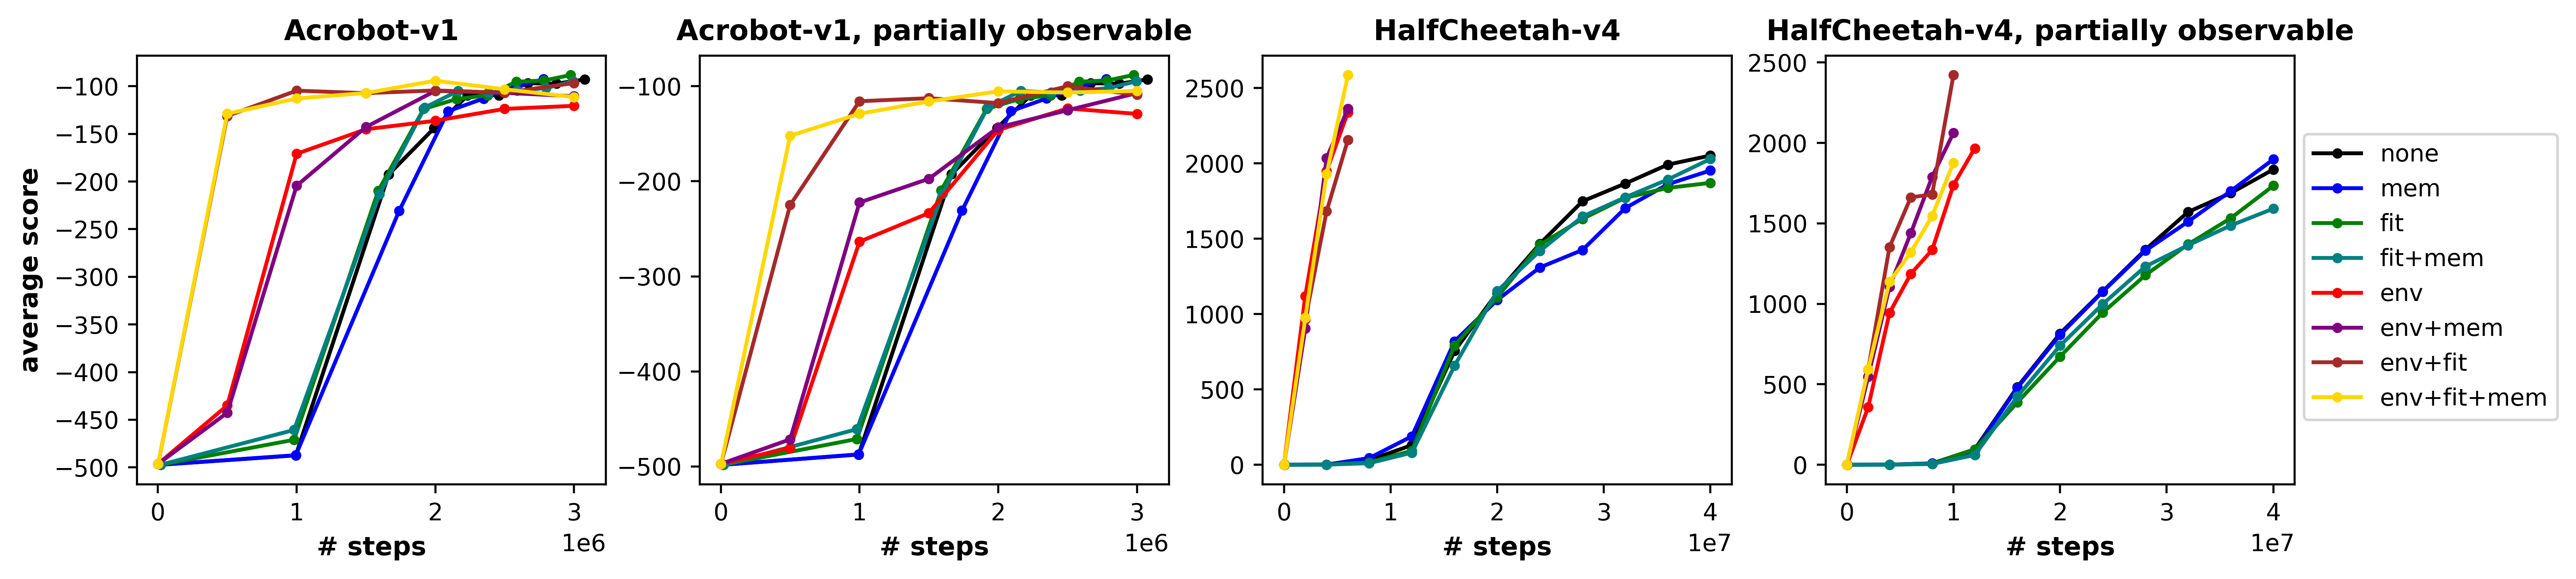

In [63]:
import os
import pickle
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

font = {"family": "sans-serif", "weight": "normal", "size": 9.2}
mpl.rc("font", **font)

plt.rc("figure", figsize=[15, 3])
plt.rc("figure", titlesize=20)
plt.rc("axes", labelsize=15)
plt.rc("axes", titlesize=15)


MAX_INT = 2**31 - 1

fig, axs = plt.subplots(1, 4, dpi=500)
max_score = 0
evaluations = np.empty((4, 8, 2000, 2))
evaluations[:] = np.nan
args = []
path_0 = Path(f"{os.environ['CNEUROMAX_PATH']}/data/gen_transfer")
label = ""
colors = {
    "none": "black",
    "env": "red",
    "fit": "green",
    "mem": "blue",
    "env+fit": "brown",
    "env+mem": "purple",
    "fit+mem": "teal",
    "env+fit+mem": "gold",
}
for i, env in enumerate(["Acrobot-v1", "HalfCheetah-v4"]):
    path_1 = "acrobot_" if env == "Acrobot-v1" else "half_cheetah_"
    for partial_obs in [False, True]:
        path_3 = f"agent.config.partial_obs.{partial_obs}~"
        for env_transfer in [False, True]:
            path_2 = "env_transfer/" if env_transfer else "no_env_transfer/"
            num_gens = 5000 if env_transfer else 1000
            for fit_transfer in [False, True]:
                path_4 = f"config.fit_transfer.{fit_transfer}~"
                for mem_transfer in [False, True]:
                    path_5 = f"config.mem_transfer.{mem_transfer}/"
                    label = ""
                    if env_transfer:
                        label += "env+"
                    if fit_transfer:
                        label += "fit+"
                    if mem_transfer:
                        label += "mem"
                    if label == "":
                        label = "none"
                    if label[-1] == "+":
                        label = label[:-1]
                    j = (
                        int(env_transfer) * 4
                        + int(fit_transfer) * 2
                        + int(mem_transfer)
                    )
                    step = num_gens // 20
                    if env == "HalfCheetah-v4":
                        step = num_gens // 10
                    for k, gen in enumerate(
                        [
                            1,
                            *list(
                                range(
                                    step,
                                    num_gens + 1,
                                    step,
                                ),
                            ),
                        ],
                    ):
                        path = (
                            path_0
                            / f"{path_1}{path_2}{path_3}{path_4}{path_5}"
                            / f"{gen}/evaluation.pkl"
                        )
                        if not path.exists():
                            continue
                        with path.open("rb") as f:
                            data = pickle.load(file=f)
                        scores: np.ndarray = data[0]
                        total_num_env_steps: int = data[1]
                        if evaluations[i, j, k][1] < total_num_env_steps:
                            break
                        mean_score = scores.mean()
                        if not (env_transfer or fit_transfer or mem_transfer):
                            mean_score = scores.mean()

                            evaluations[i, j, k] = [
                                mean_score,
                                total_num_env_steps,
                            ]
                        else:
                            mean_score = scores.mean()
                            evaluations[i, j, k] = [
                                mean_score,
                                total_num_env_steps,
                            ]
                            if mean_score >= max_score:
                                print(path)
                                print(k)
                                break

                        if (
                            env == "Acrobot-v1"
                            and total_num_env_steps >= 0.29e7
                        ):
                            break

                    if not (env_transfer or fit_transfer or mem_transfer):
                        print(evaluations[i, j])
                        min_score = np.nanmin(evaluations[i, j, :, 0], axis=0)
                        max_score = np.nanmax(evaluations[i, j, :, 0], axis=0)
                        print(min_score)
                        print(max_score)
                        percent = 0 if env == "Acrobot-v1" else 0
                        almost_max_score = (
                            max_score - (max_score - min_score) * percent
                        )
                        print(almost_max_score)
                        almost_max_score_index = np.where(
                            evaluations[i, j, :, 0] >= almost_max_score,
                        )[0][0]
                        print(almost_max_score_index)
                        max_score_index = np.nanargmax(
                            evaluations[i, j, :, 0],
                            axis=0,
                        )
                        print(max_score_index)
                        evaluations[
                            i, j, almost_max_score_index + 1 :
                        ] = np.nan

                    axs[i * 2 + partial_obs].plot(
                        evaluations[i, j, :, 1],
                        evaluations[i, j, :, 0],
                        ".-",
                        label=label,
                        c=colors[label],
                    )
                    title = env
                    if partial_obs:
                        title += ", partially observable"
                    axs[i * 2 + partial_obs].set_title(
                        title, {"fontsize": 11, "fontweight": "bold"}
                    )
                    axs[i * 2 + partial_obs].set_xlabel(
                        "# steps",
                        {"fontsize": 10, "fontweight": "bold"},
                    )
axs[0].set_ylabel("average score", {"fontsize": 10, "fontweight": "bold"})
axs[0].legend(loc=[4.62, 0.15])
plt.show()